In [14]:
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
import tensorflow as tf
import sys
import pathlib
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data = pathlib.Path('/content/gdrive/MyDrive/wildlife_presence')

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


# New Section

In [5]:
root_path = sys.path[1]

In [6]:
img_path = data
img_size = 528
batch_size=32
classes = 2

In [7]:
# Modified Network allowing for transfer learning
def build_efficientnet():
    inputs = layers.Input(shape=(img_size, img_size, 3))  # Construct the expected image input
    model = EfficientNetB6(include_top=False,
                           input_tensor=inputs,
                           weights='imagenet')  # Initialize efficientnet model with imagenet weights
    model.trainable = False  # Freeze the pre-trained weights

    # Rebuild the top layers
    x = Sequential()
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)

    # Initialize model
    model = Model(inputs=model.input, outputs=predictions, name='EfficientNet')
    optimizer = Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [8]:
def import_dataset(file_path: str):

    train_ds = image_dataset_from_directory(directory=file_path,
                                            validation_split=0.2,
                                            subset='training',
                                            seed=123,
                                            image_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            labels='inferred',
                                            label_mode='categorical')
    val_ds = image_dataset_from_directory(directory=file_path,
                                          validation_split=0.2,
                                          subset='validation',
                                          seed=123,
                                          image_size=(img_size, img_size),
                                          batch_size=batch_size,
                                          labels='inferred',
                                          label_mode='categorical')

    print(train_ds.class_names)
    return train_ds, val_ds

In [9]:
def train_top_weights(train_ds, test_ds):
  with strategy.scope():
    model = build_efficientnet()

  epochs = 25
  hist = model.fit(train_ds, epochs=epochs, validation_data = test_ds, verbose=2)
  return model, hist

In [15]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.title("Wildlife Presence Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"])
    plt.show

In [11]:
    # Generate dataset and pre-tune
    train_ds, eval_ds = import_dataset(img_path)
    train_ds = train_ds.prefetch(AUTOTUNE)

    model, hist = train_top_weights(train_ds, eval_ds)

Found 84 files belonging to 2 classes.
Using 68 files for training.
Found 84 files belonging to 2 classes.
Using 16 files for validation.
['Absent', 'Present']
165234480/165234480 [==============================] - 1s 0us/step
Epoch 1/25
3/3 - 55s - loss: 1.2941 - accuracy: 0.7500 - val_loss: 0.6389 - val_accuracy: 0.9375 - 55s/epoch - 18s/step
Epoch 2/25
3/3 - 4s - loss: 0.7309 - accuracy: 0.9412 - val_loss: 0.3739 - val_accuracy: 0.8125 - 4s/epoch - 1s/step
Epoch 3/25
3/3 - 5s - loss: 0.8104 - accuracy: 0.8235 - val_loss: 0.3069 - val_accuracy: 0.9375 - 5s/epoch - 2s/step
Epoch 4/25
3/3 - 5s - loss: 0.1745 - accuracy: 0.9559 - val_loss: 0.6424 - val_accuracy: 0.9375 - 5s/epoch - 2s/step
Epoch 5/25
3/3 - 4s - loss: 0.2439 - accuracy: 0.9559 - val_loss: 0.8361 - val_accuracy: 0.9375 - 4s/epoch - 1s/step
Epoch 6/25
3/3 - 5s - loss: 0.1575 - accuracy: 0.9706 - val_loss: 0.7649 - val_accuracy: 0.9375 - 5s/epoch - 2s/step
Epoch 7/25
3/3 - 5s - loss: 0.1470 - accuracy: 0.9706 - val_loss: 0.

NameError: ignored

ValueError: ignored

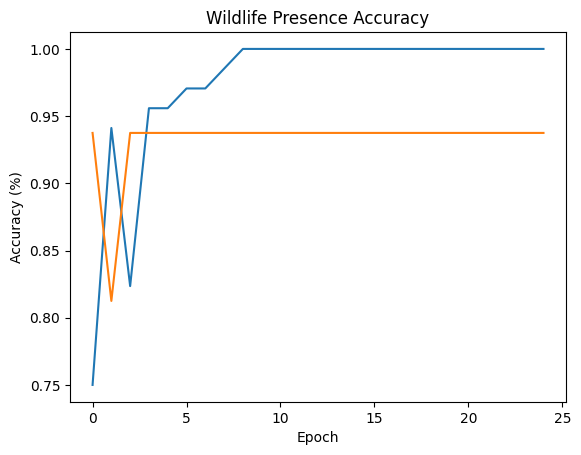

In [16]:
plot_hist(hist)